In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
Candledf=pd.read_csv('../result.dat',low_memory=False)
Candledf['ndatetime']=pd.to_datetime(Candledf['ndatetime'],format='%Y-%m-%d %H:%M:%S.%f')
print(Candledf.tail())

                ndatetime   open   high    low  close  volume
10107 2021-11-04 11:33:58  17122  17131  17107  17107   12000
10108 2021-11-04 12:04:07  17106  17130  17088  17091   12000
10109 2021-11-04 12:36:30  17091  17113  17090  17091   12000
10110 2021-11-04 13:10:55  17091  17103  17075  17075   12000
10111 2021-11-04 13:34:30  17075  17076  17050  17075   11866


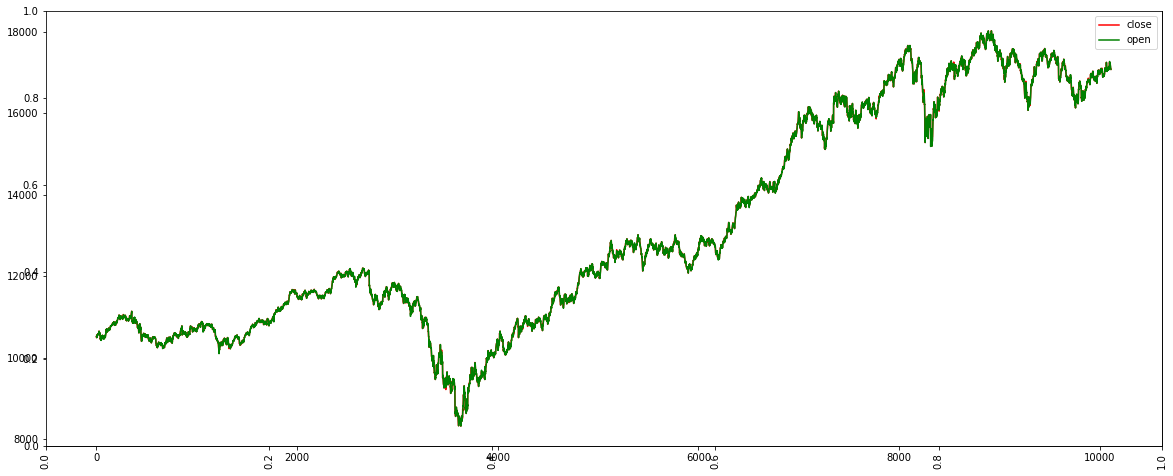

In [49]:
fig=plt.figure(figsize=(20,8))
plt.xticks(rotation = 90)  
ax1 = fig.add_subplot(111)
ax1.plot(Candledf.close,color='red',label='close')
ax1.plot(Candledf.open,color='green',label='open')
plt.legend()
plt.savefig('12K.png')

In [50]:
test = Candledf[-300:]
stock = Candledf[:Candledf.shape[0]-300]

test = test.close
train_set = stock.close

In [51]:
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range = (0, 1))
#需將資料做reshape的動作，使其shape為(資料長度,1) 
train_set= train_set.values.reshape(-1,1)
training_set_scaled = sc.fit_transform(train_set)

In [52]:
#需將資料做reshape的動作，使其shape為(資料長度,1) 

test_set = test.values.reshape(-1,1)

X_train = [] 
y_train = []
for i in range(10,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-10:i-1, 0]) 
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = [] 
y_test = []
for i in range(10,len(test_set)):
    X_test.append(test_set[i-10:i-1, 0]) 
    y_test.append(test_set[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test) 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)

(9802, 9, 1)


In [53]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout,BatchNormalization

In [57]:
keras.backend.clear_session()
regressor = Sequential()
regressor.add(LSTM(units = 10, input_shape = (9, 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
613/613 [==============================] - 17s 24ms/step - loss: 0.0245
Epoch 2/5
613/613 [==============================] - 14s 23ms/step - loss: 1.7995e-04
Epoch 3/5
613/613 [==============================] - 14s 23ms/step - loss: 1.5509e-04
Epoch 4/5
613/613 [==============================] - 14s 22ms/step - loss: 1.3736e-04
Epoch 5/5
613/613 [==============================] - 14s 23ms/step - loss: 1.2010e-04


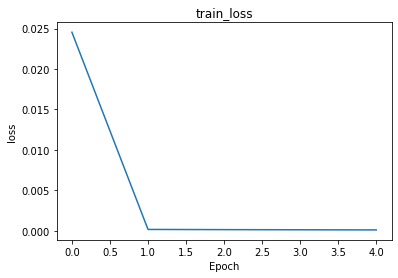

In [58]:
history = regressor.fit(X_train, y_train, epochs = 5, batch_size = 16)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot( history.history["loss"])

In [59]:
dataset_total = Candledf.close
inputs = dataset_total[len(dataset_total) - len(test) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i-1, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
#使用sc的 inverse_transform將股價轉為歸一化前
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

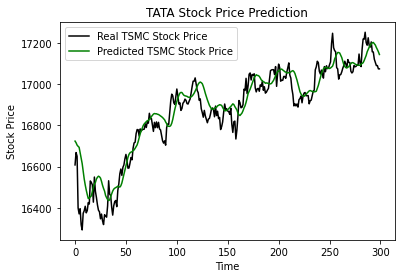

In [60]:
newtest = test.reset_index(drop=True)
plt.plot(newtest, color = 'black', label = 'Real TSMC Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSMC Stock Price')
plt.title('TATA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()